In [1]:
import pandas as pd
from statsmodels import graphics
import statsmodels.api as sm
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
from tqdm import tqdm_notebook as tqdm
from scipy.stats import shapiro
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model as ARCH
from functions import *
warnings.filterwarnings("ignore")
plt.style.use("seaborn")
plt.rcParams["figure.figsize"] = 15, 5
plt.rcParams["lines.linewidth"] = 1

In [2]:
data = pd.read_csv(r"USDJPY=X.csv")
data["Date"] = data["Date"].apply(lambda x: dt.datetime.strptime(x, "%Y-%m-%d"))
data.set_index(keys="Date", inplace=True)
data.ffill(inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-02-17,114.134003,114.495003,113.389000,114.080002,114.080002,0.0
2016-02-18,114.291000,114.291000,113.620003,114.279999,114.279999,0.0
2016-02-19,113.271004,113.272003,112.731003,113.250000,113.250000,0.0
2016-02-22,112.526001,113.364998,112.526001,112.488998,112.488998,0.0
2016-02-23,112.953003,112.971001,111.789001,112.971001,112.971001,0.0


For this project, we will work with only the Close values of the USD/JPY Exchange Rate.

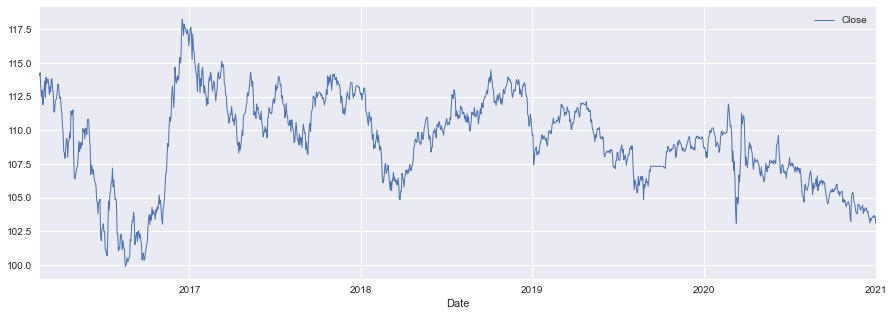

In [3]:
data = data[["Close"]]
data.plot()
plt.show()

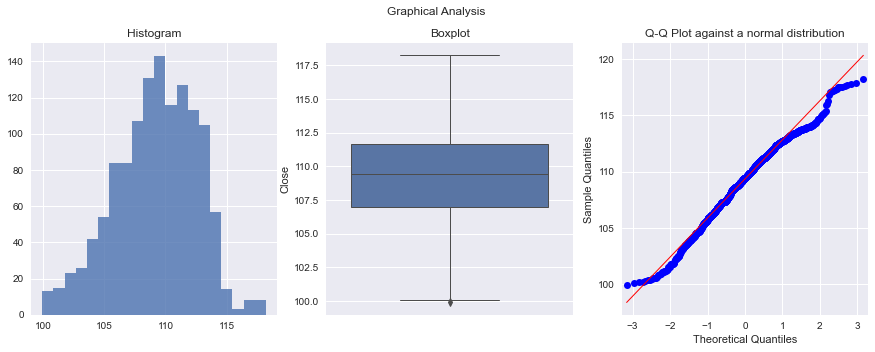

In [4]:
graphics(data)

We can see a clear downtrend in the data and maybe even a seasonal pattern. Let us look into this further

We shall now create a histogram to find the out how the data is distributed.

The distribution of the data seems to be skewed towards the right. Let us try to take the difference of each value

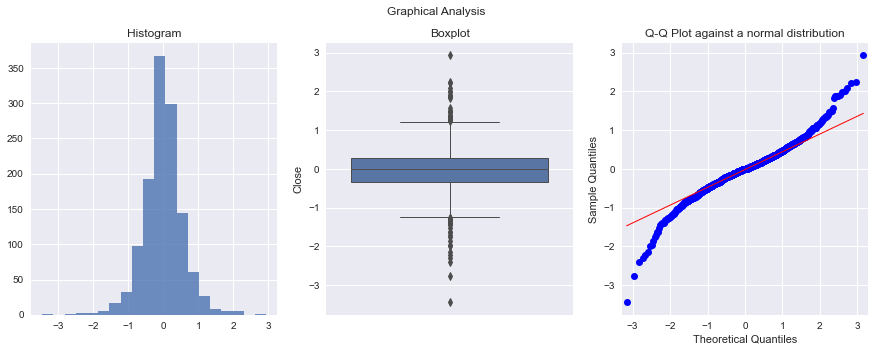

In [5]:
newData = data.diff()
newData = newData[1:]  # First value is NaN due to differencing
graphics(newData)

It seems as though the new distribution has fat-tails and a lot of outliers

Let us see what a boxplot tells us

The Q-Q Plot shows us that the distribution of the differenced data has fat tails

Let us perform a Shapiro test just to verify our assumption

In [6]:
shapiro_normality(data)
check_stationarity(data)


------Testing for Normality------ 

We reject the Null Hypothesis
The data can not be assumed to be Normally distributed

------Checking for Stationarity------ 

We do not Reject the Null Hypothesis
The data can not be assumed to be Stationary


True

Even thoguh the data is not Normally distributed, it is stationary. Since Stationarity is the only requirement of ARIMA, we shall move on with the project

We want to find out if autocorrelation is present in our time series data

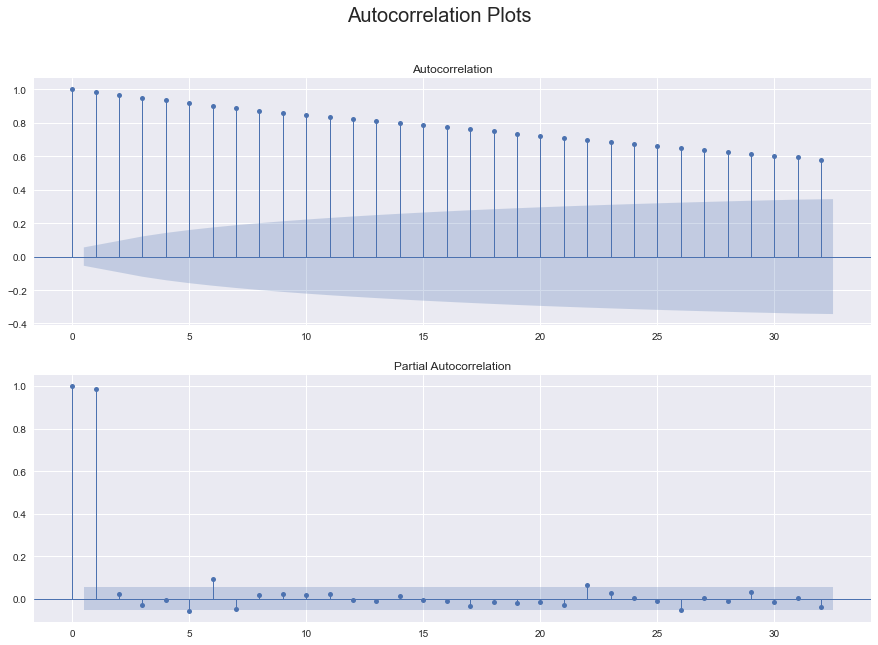

In [7]:
check_autocorrelation(data)

As visible from the plots, there seems to be a high autocorrelation with lag order 1. Hence let us check
for autocorrelation in our differenced data

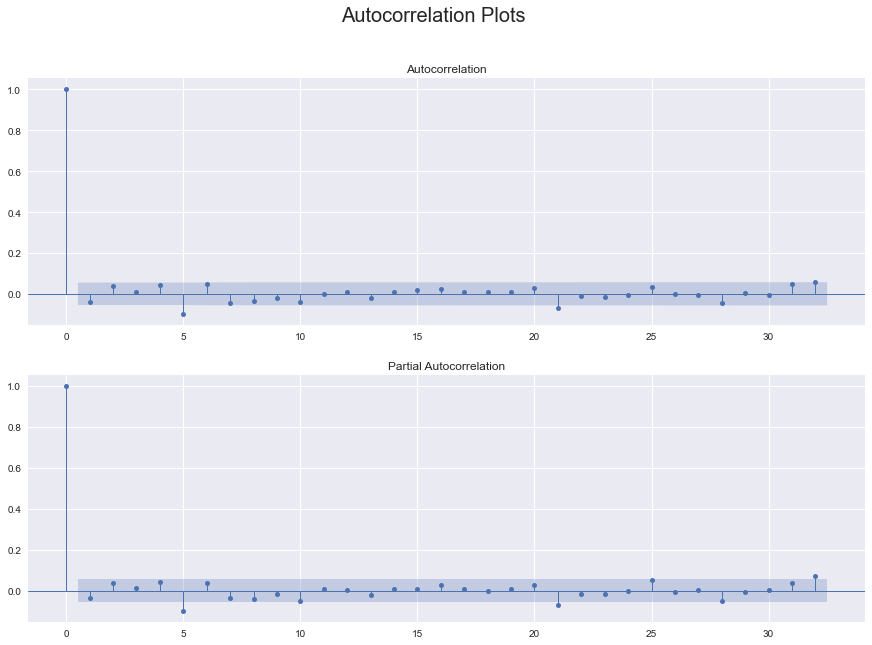

In [8]:
check_autocorrelation(newData)

Our differenced data seems to have slight autocorrelation with lag order 5


ARIMA requires that we find out p, d, q for the model first.

We want to now split our data into Train and Testing Data

We shall choose 80% of the data to be training data and the rest shall serve as test data

In [9]:
trainSize = int(len(newData) * 0.8)
trainSet = newData[:trainSize]
testSet = newData[trainSize:]

In [10]:
ARIMA_model, bestOrder = find_best_arima(trainSet)
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1017
Model:                 ARIMA(4, 1, 3)   Log Likelihood                -878.990
Date:                Sun, 21 Feb 2021   AIC                           1775.981
Time:                        17:24:35   BIC                           1820.294
Sample:                    02-18-2016   HQIC                          1792.810
                         - 01-10-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.065e-06   2.32e-09   -459.797      0.000   -1.07e-06   -1.06e-06
ar.L1         -1.2494      0.128     -9.752      0.000      -1.500      -0.998
ar.L2         -0.7038      0.121     -5.804      0.000      -0.941      -0.466
ar.L3          0.0403      0.046      0.873      0.383      -0.050       0.131
ar.L4          0.1064      0.029      3.654      0.000       0.049       0.163
ma.L1          0.2099      0.213      0.986      0.324      -0.207       0.627
ma.L2         -0.5210      0.213     -2.447      0.014      -0.938      -0.104
ma.L3         -0.6885      0.151     -4.567      0.000      -0.984      -0.393
sigma2         0.3281      0.052      6.253      0.000       0.225       0.431
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               327.89
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.54e+24. Standard errors may be unstable.
"""

We have now found the best fit ARIMA model. We now want to use it to forecast future values

In [11]:
ARIMA_model = ARIMAResults.load("ARIMA_model.pkl")

In [12]:
forecastLength = len(testSet)
ARIMA_forecast = ARIMA_model.get_forecast(steps=forecastLength)

The get_forecast() method returns an array of predictions, std_erros, and confidence internvals

We want to plot the testSet and the predicted values side by side to see how well our model can forecast

In [13]:
predictedArray = pd.DataFrame(
    data={
        "Prediction": ARIMA_forecast.predicted_mean,
        "Confidence_Interval_1": ARIMA_forecast.conf_int(0.05)["lower Close"],
        "Confidence_Interval_2": ARIMA_forecast.conf_int(0.05)["upper Close"],
    }
)


We inverse difference our time series so that we are able to compare it to a naive forecast

In [14]:
testSet = testSet + data[trainSize:].shift(1)[1:]


for idx, i in enumerate(predictedArray.index):

    predictedArray.Prediction[i] = (
        predictedArray.Prediction[i] + data[trainSize:].shift(1)[1:].iloc[idx]
    )
    predictedArray.Confidence_Interval_1[i] += data[trainSize:].shift(1).iloc[idx]
    predictedArray.Confidence_Interval_2[i] += data[trainSize:].shift(1)[1:].iloc[idx]

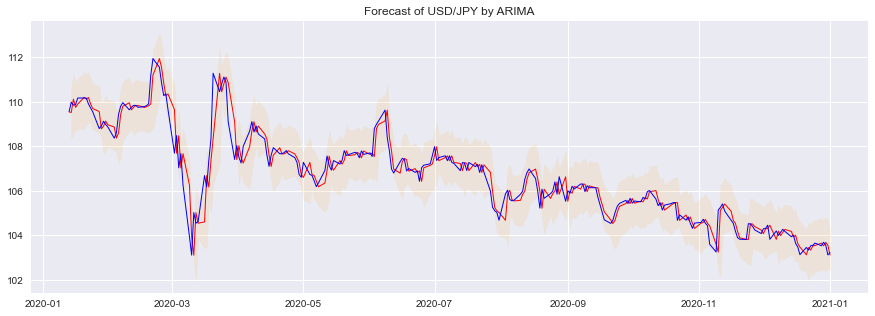


------------- CONGRATULATIONS !! -------------

The ARIMA model has achieved an rMAPE of: 6.0935


In [15]:
plot_forecast(predictedArray, testSet, algo="ARIMA")

MAPE = np.mean(abs(predictedArray.Prediction.values - testSet.values) / testSet.values)
naiveForecast = testSet.shift(1).bfill()
naiveMAPE = np.mean((abs(naiveForecast.values - testSet.values) / testSet.values)[1:])
rMAPE = MAPE / naiveMAPE

print("\n------------- CONGRATULATIONS !! -------------\n")
print("The ARIMA model has achieved an rMAPE of: {}".format(round(rMAPE, 4)))


Now let us move on to trying to forecast the ARIMA residuals using a GARCH model

We shall use the order (1,1) for the GARCH model

In [16]:
ARIMA_residuals = ARIMA_model.resid
GARCH_model = ARCH(ARIMA_residuals, vol="GARCH", p=1, q=1).fit(disp="off")
GARCH_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -808.228
Distribution:                  Normal   AIC:                           1624.46
Method:            Maximum Likelihood   BIC:                           1644.16
                                        No. Observations:                 1017
Date:                Sun, Feb 21 2021   Df Residuals:                     1016
Time:                        17:24:36   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.7577e-03  1.542e-02      0.568      0.570 [-2.147e-02,3.898e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.7678e-03  3.671e-03      0.481      0.630 [-5.428e-03,8.964e-03]
alpha[1]       0.0355  4.990e-02      0.711      0.477   [-6.230e-02,  0.133]
beta[1]        0.9577  5.836e-02     16.411  1.604e-60      [  0.843,  1.072]
=============================================================================

Covariance estimator: robust
"""

In [17]:
ARIMA_result = ARIMA_model.get_forecast(steps=forecastLength)
predicted_mu = ARIMA_result.predicted_mean
# Use GARCH to predict the residual
GARCH_result = GARCH_model.forecast(horizon=forecastLength)
predicted_et = GARCH_result.mean.iloc[-1].values
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et

In [18]:
predictedArray_ARIMA_GARCH = pd.DataFrame(
    data={
        "Prediction": prediction,
        "Confidence_Interval_1": ARIMA_result.conf_int(0.05)["lower Close"],
        "Confidence_Interval_2": ARIMA_result.conf_int(0.05)["upper Close"],
    }
)

In [19]:
for idx, i in enumerate(predictedArray_ARIMA_GARCH.index):

    predictedArray_ARIMA_GARCH.Prediction[i] = (
        predictedArray_ARIMA_GARCH.Prediction[i]
        + data[trainSize:].shift(1)[1:].iloc[idx]
    )
    predictedArray_ARIMA_GARCH.Confidence_Interval_1[i] += (
        data[trainSize:].shift(1).iloc[idx]
    )
    predictedArray_ARIMA_GARCH.Confidence_Interval_2[i] += (
        data[trainSize:].shift(1)[1:].iloc[idx]
    )

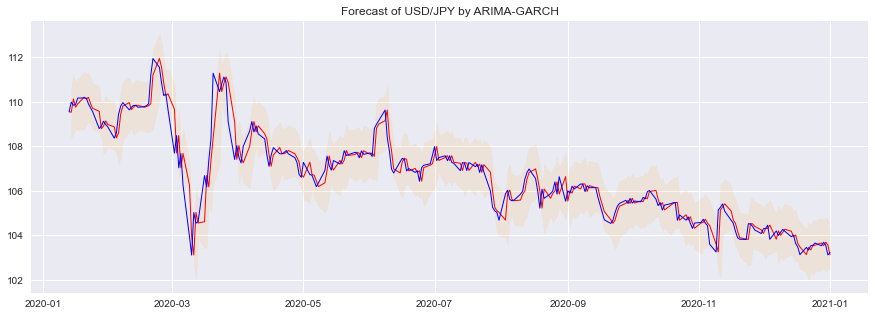


------------- CONGRATULATIONS !! -------------

The ARIMA-GARCH model has achieved an rMAPE of: 6.094


In [20]:
plot_forecast(predictedArray_ARIMA_GARCH, testSet, algo="ARIMA-GARCH")

MAPE = np.mean(
    abs(predictedArray_ARIMA_GARCH.Prediction.values - testSet.values) / testSet.values
)
naiveForecast = testSet.shift(1).bfill()
naiveMAPE = np.mean((abs(naiveForecast.values - testSet.values) / testSet.values)[1:])
rMAPE = MAPE / naiveMAPE

print("\n------------- CONGRATULATIONS !! -------------\n")
print("The ARIMA-GARCH model has achieved an rMAPE of: {}".format(round(rMAPE, 3)))

There is a slight improvement in the rMAPE score of the model over the ARIMA model but unfortunately both models are unable to predict better than a naive forecast